In [2]:
import numpy as np 
import pandas as pd

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2
import tensorflow

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image as keras_image

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import PReLU, LeakyReLU
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import seaborn as sns
from PIL import Image
import os
import random

In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install tensorflow

  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 2.0.0
    Uninstalling importlib-metadata-2.0.0:
      Successfully uninstalled importlib-metadata-2.0.0


In [3]:
path_test = "C:/Users/student/Downloads/Flowers-Dataset/flowers/"

In [4]:
CATEGORIES = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
IMG_SIZE =200

In [5]:
training = []
def createTrainingData():
  for category in CATEGORIES:
    path = os.path.join(path_test, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
      training.append([new_array, class_num])

createTrainingData()

In [6]:
random.shuffle(training)

In [7]:
X =[]
y =[]
for features, label in training:
  X.append(features)
  y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [8]:
X = X.astype('float32')
X /= 255
from keras.utils import np_utils
Y = np_utils.to_categorical(y, 5)
print(Y[100])
print(Y.shape)
print(X.shape)

[0. 0. 0. 0. 1.]
(4317, 5)
(4317, 200, 200, 3)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [10]:
n = int(len(X_test)/2)
x_valid, y_valid = X_test[:n], y_test[:n]
x_test, y_test = X_test[n:], y_test[n:]

In [11]:
print(X_train.shape)
print(y_train.shape)

(3453, 200, 200, 3)
(3453, 5)


In [12]:
print(X_test.shape)
print(y_test.shape)

(864, 200, 200, 3)
(432, 5)


In [13]:
 x_valid.shape, y_valid.shape

((432, 200, 200, 3), (432, 5))

Label:  dandelion


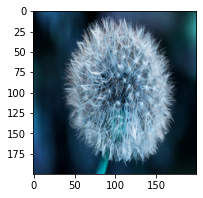

In [14]:
print('Label: ', CATEGORIES[np.argmax(y_train[7])])
plt.figure(figsize=(3,3))
plt.imshow((X_train[7]));

In [15]:
def model():
    model = Sequential()

    model.add(Conv2D(128, (3, 3), input_shape=X_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 

    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = model()

In [16]:
checkpointer = ModelCheckpoint(filepath='cnn_model.hdf5', 
                               verbose=2, save_best_only=True)

# To reduce learning rate dynamically
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=5, verbose=2, factor=0.2)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 198, 198, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 99, 99, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 97, 97, 128)       0         
                                                        

In [18]:
history = model.fit(X_train, y_train, 
                    epochs=5, batch_size=32, verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer,lr_reduction])

Epoch 1/5

Epoch 1: val_loss improved from inf to 1.08664, saving model to cnn_model.hdf5
108/108 - 204s - loss: 1.2988 - accuracy: 0.4356 - val_loss: 1.0866 - val_accuracy: 0.5880 - lr: 0.0010 - 204s/epoch - 2s/step
Epoch 2/5

Epoch 2: val_loss improved from 1.08664 to 0.93717, saving model to cnn_model.hdf5
108/108 - 212s - loss: 0.9890 - accuracy: 0.6041 - val_loss: 0.9372 - val_accuracy: 0.6505 - lr: 0.0010 - 212s/epoch - 2s/step
Epoch 3/5

Epoch 3: val_loss improved from 0.93717 to 0.87659, saving model to cnn_model.hdf5
108/108 - 211s - loss: 0.8913 - accuracy: 0.6496 - val_loss: 0.8766 - val_accuracy: 0.6759 - lr: 0.0010 - 211s/epoch - 2s/step
Epoch 4/5

Epoch 4: val_loss improved from 0.87659 to 0.81085, saving model to cnn_model.hdf5
108/108 - 210s - loss: 0.8246 - accuracy: 0.6768 - val_loss: 0.8109 - val_accuracy: 0.6968 - lr: 0.0010 - 210s/epoch - 2s/step
Epoch 5/5

Epoch 5: val_loss improved from 0.81085 to 0.79096, saving model to cnn_model.hdf5
108/108 - 208s - loss: 0.7

In [19]:
data_generator = keras_image.ImageDataGenerator(shear_range=0.3, 
                                                zoom_range=0.3,
                                                rotation_range=30,
                                                horizontal_flip=True)

dg_history = model.fit_generator(data_generator.flow(X_train, y_train, batch_size=64),
                                 steps_per_epoch = len(X_train)//64, epochs=7, verbose=2, 
                                 validation_data=(x_valid, y_valid),
                                 callbacks=[checkpointer,lr_reduction])

<ipython-input-19-116b1a1420fb>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  dg_history = model.fit_generator(data_generator.flow(X_train, y_train, batch_size=64),


Epoch 1/7

Epoch 1: val_loss improved from 0.79096 to 0.72953, saving model to cnn_model.hdf5
53/53 - 204s - loss: 0.7424 - accuracy: 0.7200 - val_loss: 0.7295 - val_accuracy: 0.7477 - lr: 0.0010 - 204s/epoch - 4s/step
Epoch 2/7

Epoch 2: val_loss did not improve from 0.72953
53/53 - 204s - loss: 0.7345 - accuracy: 0.7232 - val_loss: 0.7483 - val_accuracy: 0.7569 - lr: 0.0010 - 204s/epoch - 4s/step
Epoch 3/7

Epoch 3: val_loss improved from 0.72953 to 0.71131, saving model to cnn_model.hdf5
53/53 - 201s - loss: 0.7133 - accuracy: 0.7271 - val_loss: 0.7113 - val_accuracy: 0.7338 - lr: 0.0010 - 201s/epoch - 4s/step
Epoch 4/7

Epoch 4: val_loss improved from 0.71131 to 0.70982, saving model to cnn_model.hdf5
53/53 - 203s - loss: 0.7134 - accuracy: 0.7291 - val_loss: 0.7098 - val_accuracy: 0.7593 - lr: 0.0010 - 203s/epoch - 4s/step
Epoch 5/7

Epoch 5: val_loss improved from 0.70982 to 0.68842, saving model to cnn_model.hdf5
53/53 - 200s - loss: 0.7021 - accuracy: 0.7350 - val_loss: 0.6884 

In [20]:
model.load_weights('cnn_model.hdf5')

In [21]:
score = model.evaluate(x_test, y_test)
score

14/14 [==============================] - 5s 363ms/step - loss: 0.7218 - accuracy: 0.7477


[0.7218479514122009, 0.7476851940155029]

In [22]:
score = model.evaluate(X_train, y_train)
score

108/108 [==============================] - 40s 366ms/step - loss: 0.6264 - accuracy: 0.7857


[0.6264329552650452, 0.7856935858726501]

In [23]:
score = model.evaluate(x_valid, y_valid)
score

14/14 [==============================] - 5s 358ms/step - loss: 0.6884 - accuracy: 0.7315


[0.6884220242500305, 0.7314814925193787]

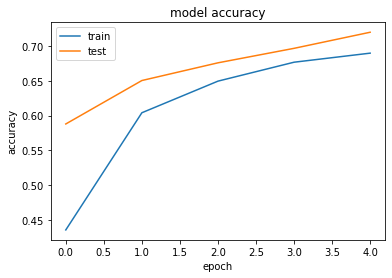

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

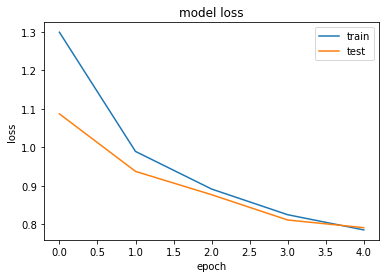

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [26]:
model.save('model.h5')

In [27]:
model1 = load_model('model.h5')

In [28]:
y_test_predict = model1.predict(x_test)

14/14 [==============================] - 5s 359ms/step


In [29]:
y_test_predict = np.argmax(y_test_predict,axis=1)

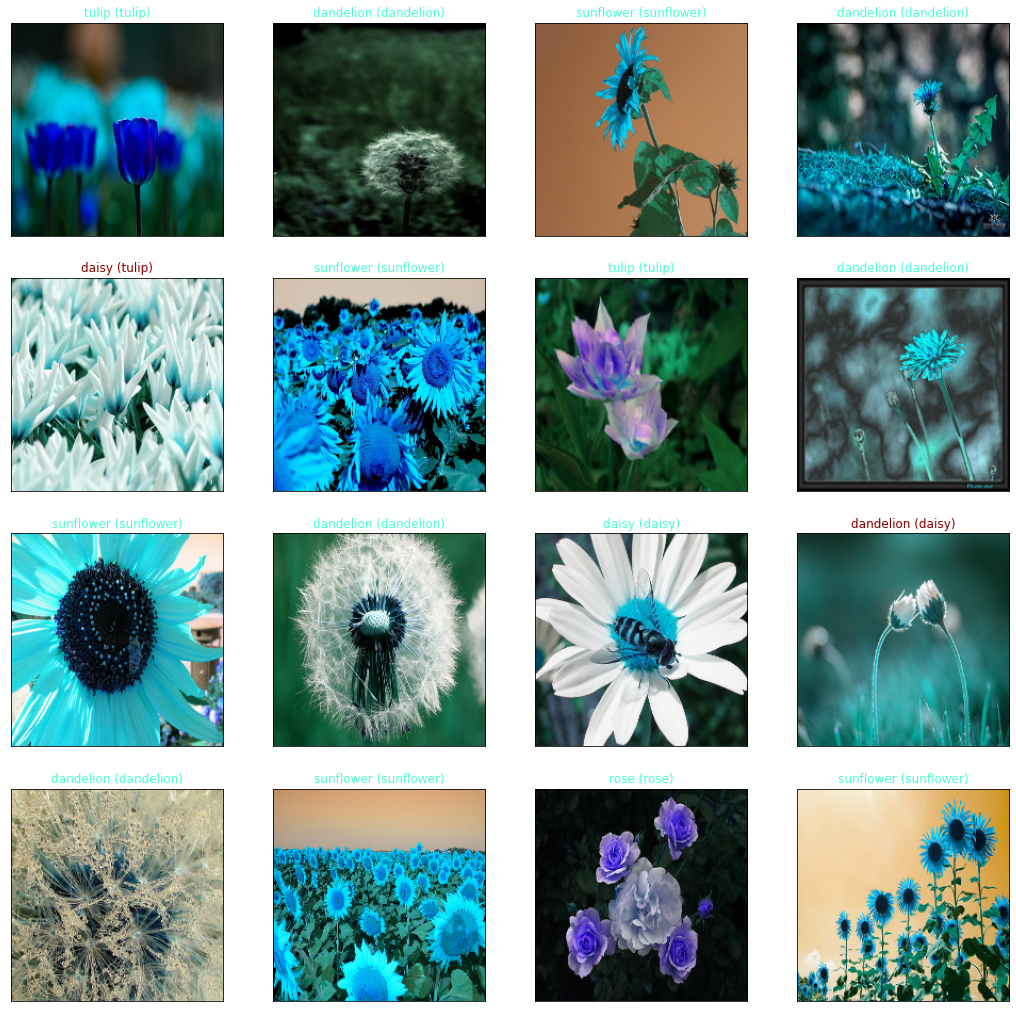

In [30]:
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(CATEGORIES[pred_idx], CATEGORIES[true_idx]),
                 color=("#48ffd1" if pred_idx == true_idx else "darkred"))